# Air BnB Project

This project will be split into four parts. 
[Another Cell](#another_cell)

- Part 1: [Data Acquistion and Cleaning](##Data+Acquistion+and+Cleaning)
- Part 2: [Data Visualisation and simple time series modeling](##Data+Vis+and+simple+time+series+modeling)
- Part 3: [ARIMA modeling](##ARIMA++Model) 
- Part 4: ARMAX model with regularization 

## Data Acquistion and Cleaning
The data was all obtained from http://insideairbnb.com/vancouver/. The individual files were scrapped and merged to allow for easier manipulation. The code for this is in a different [notebook](DataAcquisition.ipynb). 

## Data Vis and simple time series modeling
### Loading the data 
The listings directory contains multiple .txt files in comman seperated format. The first thing to do is run through this directory, read each file and then write it to a new .txt file. This file with all the combined data will make it easier to work with the data. 

In [18]:
#load relevant packages
library(ggplot2)
library(forecast)
library(tseries)
library(IDPmisc)
library(zoo)
library(xts)
library(lubridate)
library(dplyr)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#load data
df <- read.csv('combined_listing.csv',header=TRUE,na.strings=c("","NA"))

### Distribution of the price data

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

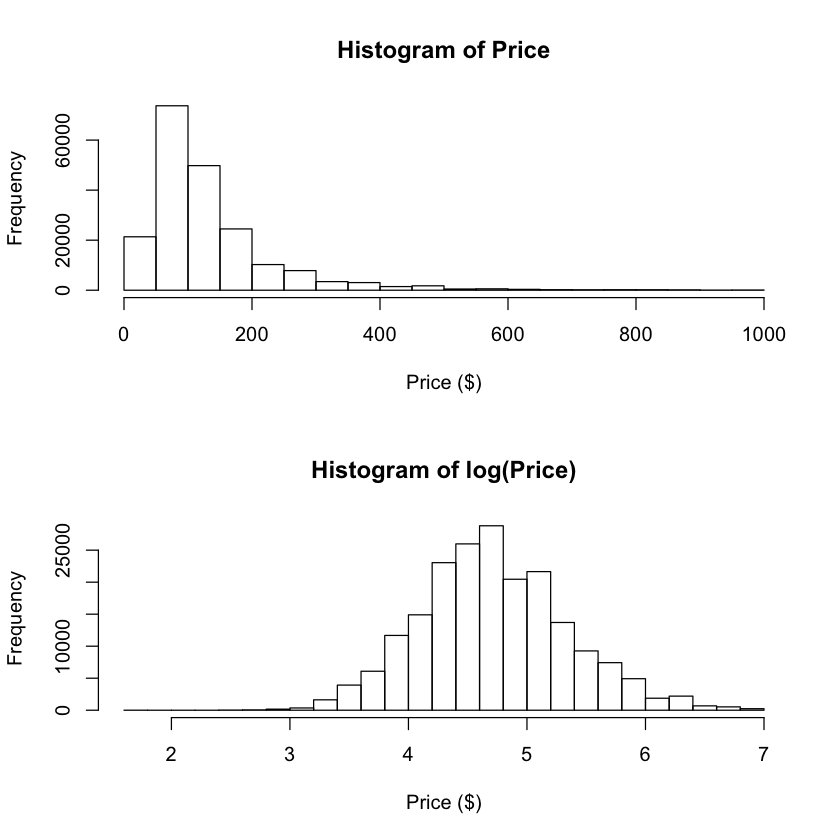

In [3]:
#create a new df to explore price and time data
n <- nrow(df)
price.col <- df[1:n,'price']
price.col = as.numeric(gsub("\\$", "", price.col))
last.review <- as.Date(df[1:n,'last_review'])

#make new dataframe with only price and last review column
ts.df <- data.frame(price.col,last.review)


#oder df by date
ts.df <- ts.df[order(as.Date(ts.df$last.review, format="%Y-%m-%d")),]


par(mfrow=c(2,1))
#histogram of the price data
hist(ts.df$price.col,breaks=20,xlab="Price ($)",main = 'Histogram of Price')

#The above plot shows that the data a strong right skew. Needs to be transformed to be more normal.
ts.df$log.price <- log(ts.df$price.col)
hist(ts.df$log.price,xlab='Price ($)',main='Histogram of log(Price)')

### Time series of the price data

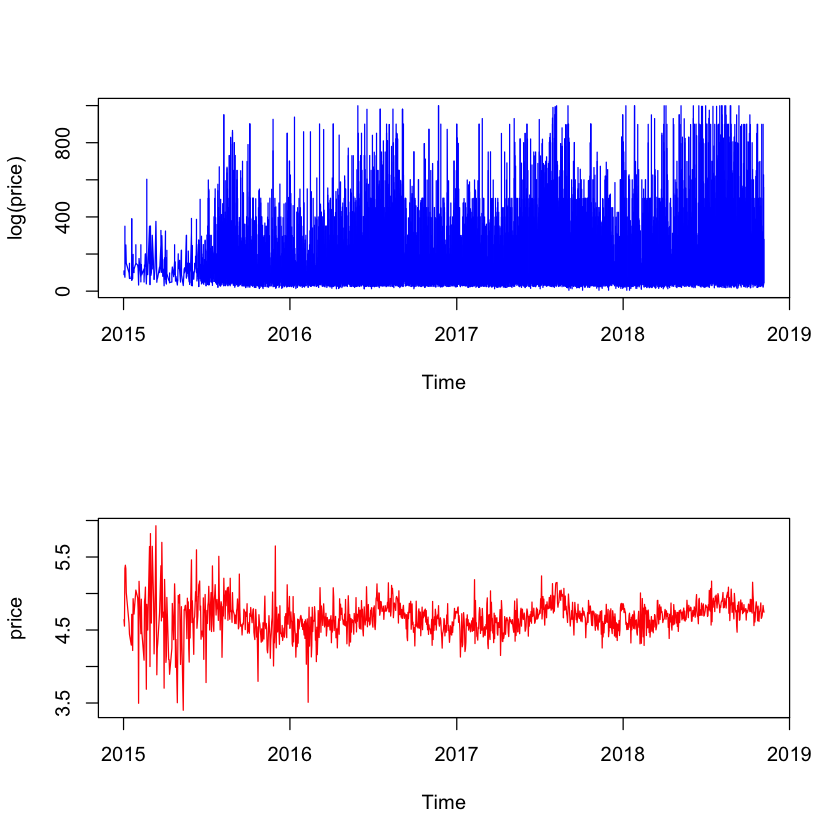

In [4]:
#better col names and clean up df
colnames(ts.df) <- c('price','date','logprice')
ts.df <- NaRV.omit(ts.df)

#get first and last date 
start_date <- ts.df$date[1]
last_date <- ts.df$date[nrow(ts.df)]

#sequence of dates for date column
date <- data.frame(seq(from=start_date,to=last_date,by='days'))
colnames(date) <- c('date')

ts.df <- subset(ts.df, ts.df$date> '2015-01-01')
par(mfrow=c(2,1))
#ts plot of raw prices. May be a little too noisy. Some filtering probably needed
plot(as.Date(ts.df$date),ts.df$price, type='l',ylab='log(price)',xlab='Time',col='blue')

#initial plot too noisy. Group by day
meanprice <-  aggregate(ts.df$logprice,by=list(ts.df$date),mean)
colnames(meanprice) <- c('date','meanprice')
meanprice <- merge(x = date, y = meanprice, by = 'date', all = TRUE)
meanprice$date <- as.Date(meanprice$date)

#remove data from before 2015. Too little of it
meanprice <- na.omit(meanprice[meanprice[['date']] > as.Date('2015-01-01') ,])

meanprice <- data.frame(meanprice)
#plot with aggregated data
plot(as.Date(meanprice$date),meanprice$meanprice,type='l',ylab='price',xlab='Time',col='red')

The time series is till quite noisy. After consulting Harry Joe, we decided it would be best to group the data by the weekly mean. This would act as a filter removing any noise. 

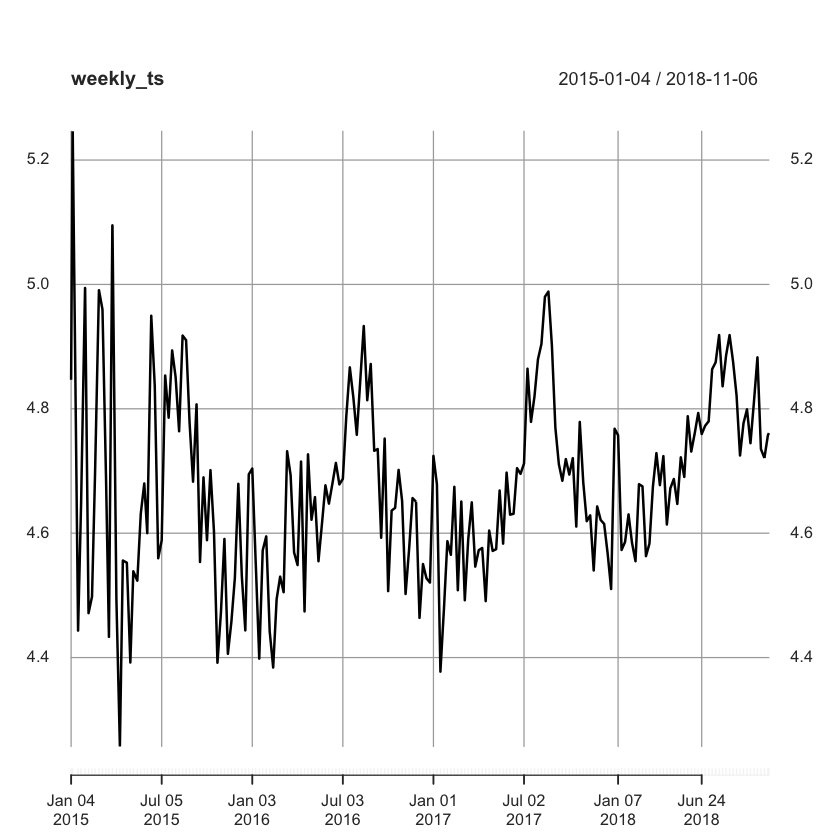

In [5]:
#looks like there could be some seasonality. Might make sense to aggregate data by week and see if there are trends. 
#group by week
daily_xts <- as.xts(meanprice$meanprice,order.by=as.Date(meanprice$date))
weekly_ts <- apply.weekly(daily_xts,mean)


#plot weekly time series
print(plot.xts(weekly_ts))

# Simple Models
This section will fit a simple [Seasonal Exponential Smoothing model](https://en.wikipedia.org/wiki/Exponential_smoothing).


#### Decompoistion of time series

From the above we can see that there is a seasonal trend with surges in price in the summer months, which may be explained by increased number of tourists visiting the city during that period. The start of the time series also shows a greater variation in price than the following months, this may be explained by the fact that this was the time when Airbnb was launched in Vancouver and people did not know how to price their homes in the market initially, but this variation seems to stabilize as time progresses with the market adjusting to the demand of the houses.

Since there is a seasonal trend the in the time series, it was decomposed into its constituent elements: seasonality, trend and random noise.

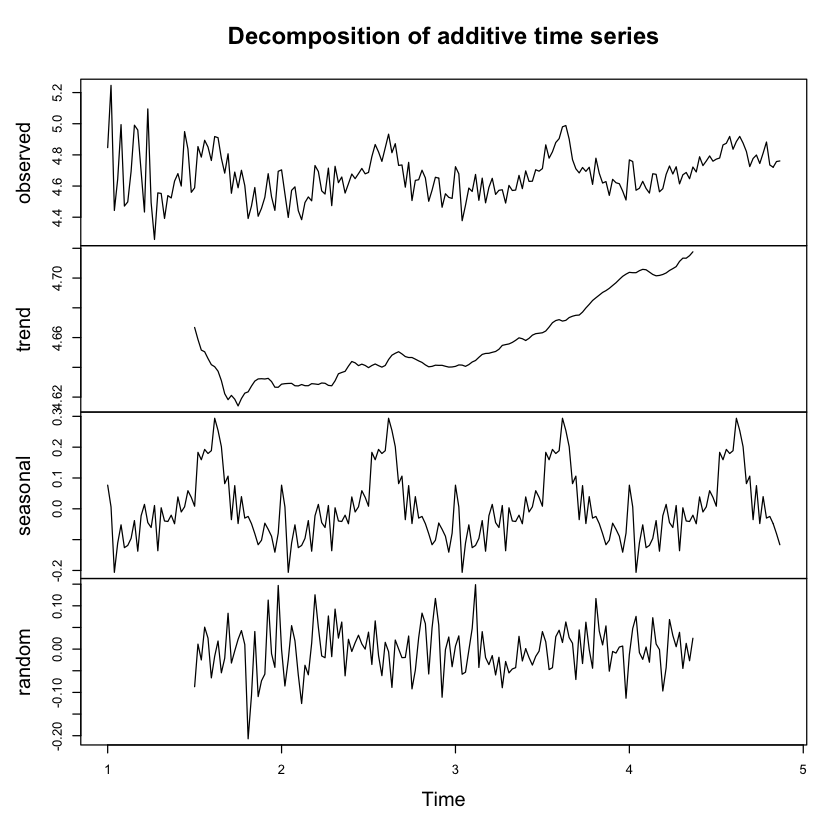

In [24]:
#decompose time series
weekly <- ts(as.numeric(weekly_ts), frequency=52)
weekly_components <- decompose(weekly)

#plot decomposistion
plot(weekly_components)

We can see that is a seasonality with price spikes in the summer. The trend also shows us that the prices initially start off quite high, followed by a drop and then a resurgence in price, possibly due to increased tourism and increased market activity. The remainder also shows that there is a lot of noise at the start, again due to uncertainty about to price a house. This slowly gets better with less variation, due to prices settling down.

Before trying to fit an ARIMA model, a Holt-Winter model was fit. This is a simple seasonal exponential smoothing model that was used as a baseline, and every other model built was compared to this.

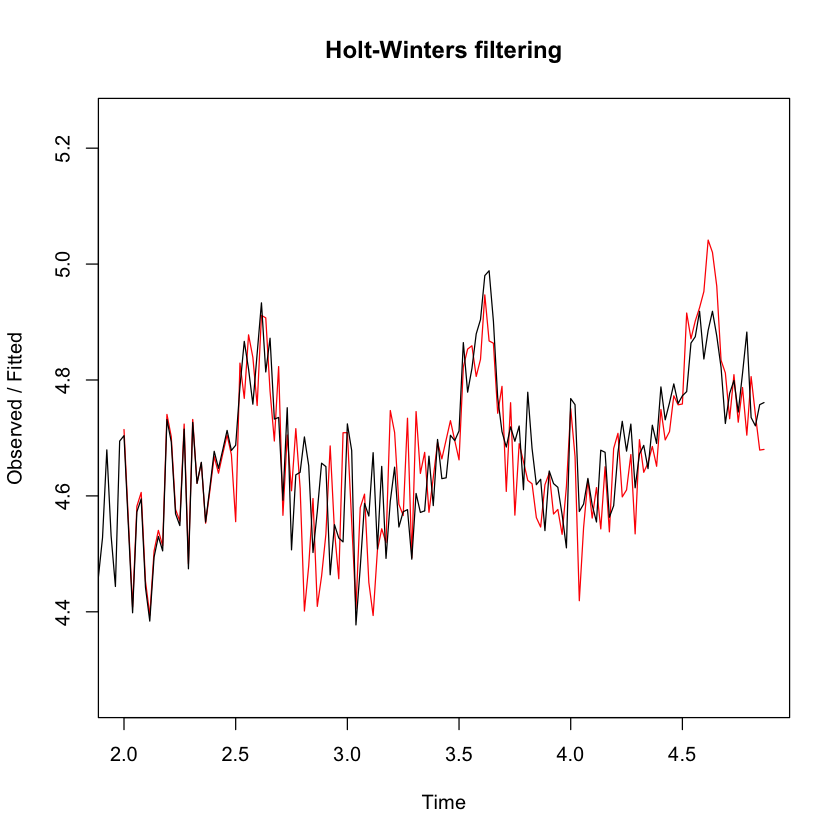

In [9]:
exposmoothing_forecasts <- HoltWinters(weekly,seasonal = 'additive')
plot(exposmoothing_forecasts)

In [25]:
#create a test set and training set
test <- window(as.numeric(weekly), start=183)
train <-window(as.numeric(weekly[1:182]))
train <- ts(train,frequency = 52)

#train models on subset of data
holtWint <- HoltWinters(train,seasonal = 'additive')

#get forecats for holdout set
hwint_fcast <- forecast(holtWint,h=20)
accuracy(hwint_fcast,test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01209956,0.08191240,0.05866524,0.2462707,1.259521,0.5335281,0.09714885,NA
Test set,-0.03107592,0.08330497,0.06437862,-0.6439210,1.334485,0.5854881,0.17338284,1.383647


The above seasonal smoothing model had a fairly good RMSE on the holdout set. More sophisticated methods can be used to validate the model accuracy than a simple holdout set, but it is a good starting point to keep things simple.

The model that was fit by R is the following: 


$$ \text{The recursion equations are below. Let d be the period length, for t > d} \\ \hat{v}_t = \alpha(z_t - \hat{s}_{t-d}) + (1 - \alpha)(\hat{v}_{t-1} + \hat{b}_{t-1}) \\
\hat{b}_t = \beta(\hat{v}_t - \hat{v}_{t-1}) + (1 - \beta)\hat{b}_{t-1})\\
\hat{s}_t = \gamma(z_t - \hat{v}_t) + (1-\gamma)\hat{s}_{t-d}\\
\hat{z}_t(h) = \hat{s}_{t+h-d} + (\hat{v}_t + h\hat{b}_t) \quad h = 1,...,d
$$

In the above recursion equations: 

- $\hat{v}_t$:  is a convex combination of the most recent deseasonalized observation and the local linear projection.

- $\hat{b}_t$ is a convex combination of the most recent trend change and the previous smoothed slope.

- $\hat{s}_t$ is a convex combination of the most recent seasonal estimate and the previous seasonal effect.

- $\hat{z}_t(h)$ is the h-step forecast for this model
 
The above recursion equations are intialized according to the deafult R method. The parameter estimates are: 
- $\alpha = 0.003607012$
- $\beta = 0.3482321$
- $\gamma = 0.6589511$

The seasonal parameters are not included for berivity. The full model can be show using: ```print(exposmoothing_forecasts)```


The red line shows the predictions made by our simple seasonal exponential smoothing model. It clearly seems to follow the trends quite nicely, however there are parts that dont line up exactly. Nonetheless it a good starting point. 

## ARIMA Model

Fitting an ARIMA model requires the assumpition that the time series is stationary. A series is said to be stationary when its mean, variance, and autocovariance are time invariant. A visual inspection shows that the time series may not neccesarily be stationary. To confirm this a Variogram and a formal ADF (augmented Dickey Fuller Test was conducted).

## Model 
$$\text{ARIMA}(p,d,q)(P,D,Q)_S$$

The ARIMA model will be used.To find the parameters for this model ACF and PACF plots wil be used. Parameters: 
- p: non-seasonal AR component
- d: non-seasonal differencing order
- q: non-seasonal MA component
- P seasonal AR component
- D: seasonal differencing order
- Q: seasona MA component
- S: season period

The steps to determine them will be: 
 
1. Decompose timeseries into seasonal and non-seasonal parts
2. Determine p,d,q components of this part via acf,pacf and test running ARIMA models
3. Repeat 2 for P,D,Q
4. Fit model with found parameters and season. See if anything can be improved through changing parameters a littl more

Note ARIMA models work on the assumption of stationarity. 

### Determining p,d,q

#### Testing stationarity


	Augmented Dickey-Fuller Test

data:  weekly
Dickey-Fuller = -3.4953, Lag order = 5, p-value = 0.04448
alternative hypothesis: stationary


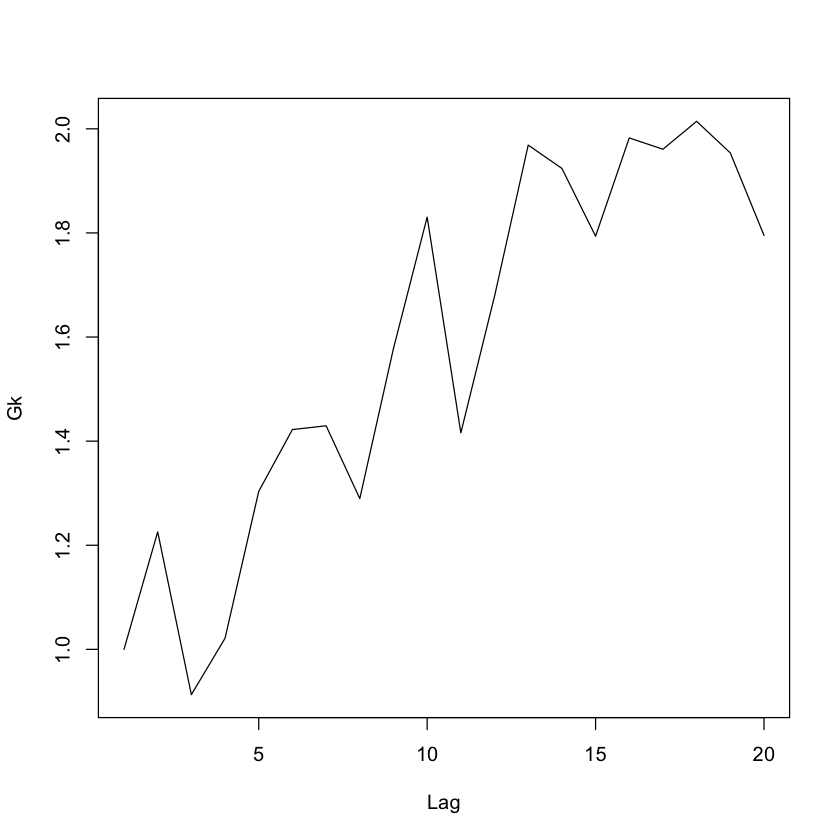

In [26]:
#testing stationarity
adf.test(weekly,alternative = "stationary")

#Variogram defintion: 
#G(k) = Var(vt+k - vt)/Var(zt+1 - zt)
Var <- var(diff(weekly,lag=1))
Gk <- vector(mode='numeric',length=48)
for (k in 1:48){
    Gk[k] <- var(diff(weekly,lag=k))/Var
}

plot(1:20,Gk[1:20],ylab='Gk',xlab='Lag',type='l')

Both the ADF test and the Varoigram suggest that our time series is borderline not stationary. A variogram for a stationary time series should level out, however this is clearly increasing. The above Variogram shows a clear trend. This suggests a simple differencing by 1 or 2 steps may needed. 

Warning message in adf.test(diff_ds, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  diff_ds
Dickey-Fuller = -8.0098, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


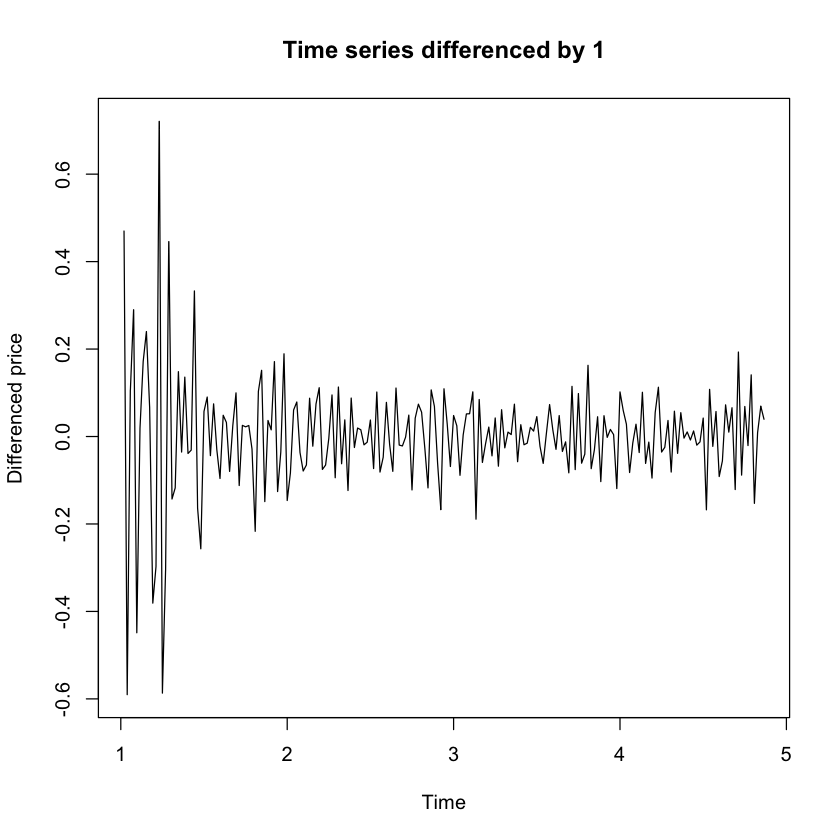

In [27]:
#deseason then difference
deseasoned <- weekly - weekly_components$seasonal
diff_ds <- diff(deseasoned,differences = 1)
adf.test(diff_ds,alternative = 'stationary')
plot(diff_ds,type='l',main='Time series differenced by 1',ylab='Differenced price')

temp <- diff_ds[25:length(diff_ds)]

The time series was differenced by 1-step as seen above. The new differenced time series appears to be stationary thus we assume ```d = 1``` in our model. To determine the other parameters the ACF and PACF were plotted.

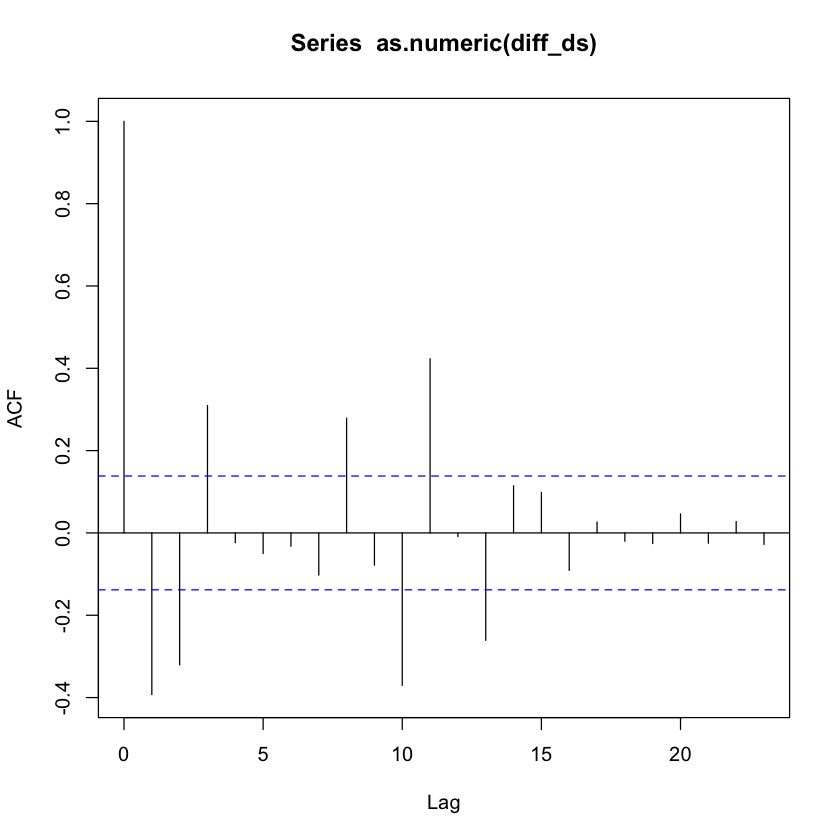

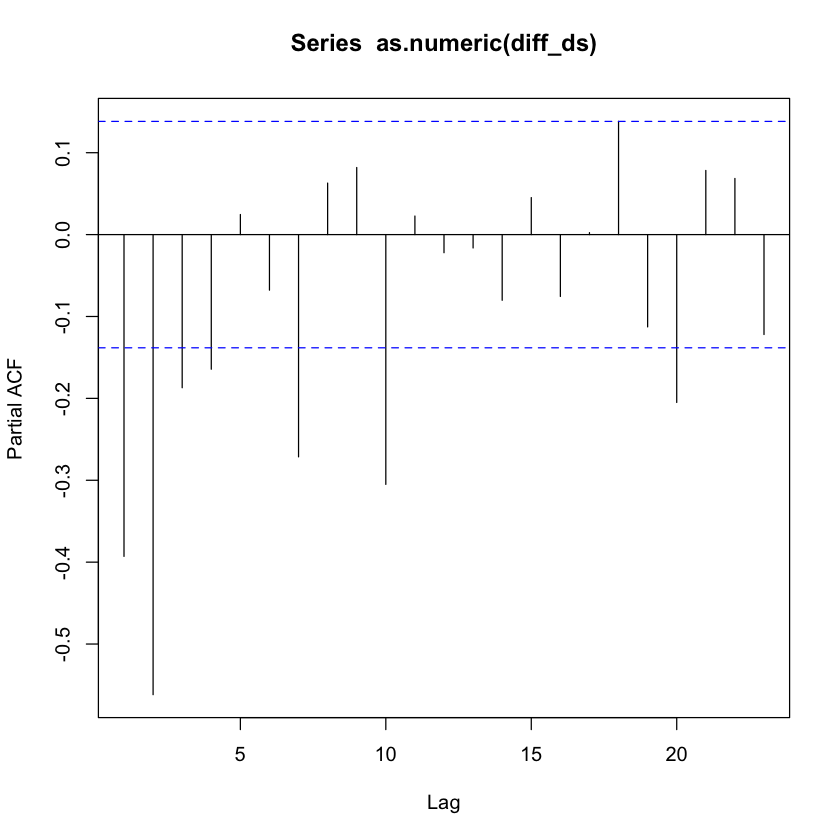

In [30]:
acf(as.numeric(diff_ds))
pacf(as.numeric(diff_ds))

The ACF plot shows lags 1 and 2 are signficant(pssibly some later ones), while the PACF shows that lags 1,2,3 are signficant. (possibly lags 11 and 12, but we can ignore those for now to keep things simple).

```p = 3``` ```q = 2```

Since there are a lot of signficant lags, it might be hard to decide what parameters to choose for the model. A good starting point is the auto.arima() function. This find the best fitting model based on either AIC or BIC. From the above acf and pacf plots a ARIMA(3,1,2) may be approriate. Lets see what R decides is best for us though.

In [32]:
#fitting on deseasonal data
auto.arima(diff_ds,seasonal = FALSE)

Series: diff_ds 
ARIMA(3,0,1) with zero mean 

Coefficients:
         ar1      ar2     ar3      ma1
      0.1279  -0.1882  0.3527  -0.9108
s.e.  0.0962   0.0834  0.0913   0.0609

sigma^2 estimated as 0.009473:  log likelihood=184.22
AIC=-358.44   AICc=-358.13   BIC=-341.92

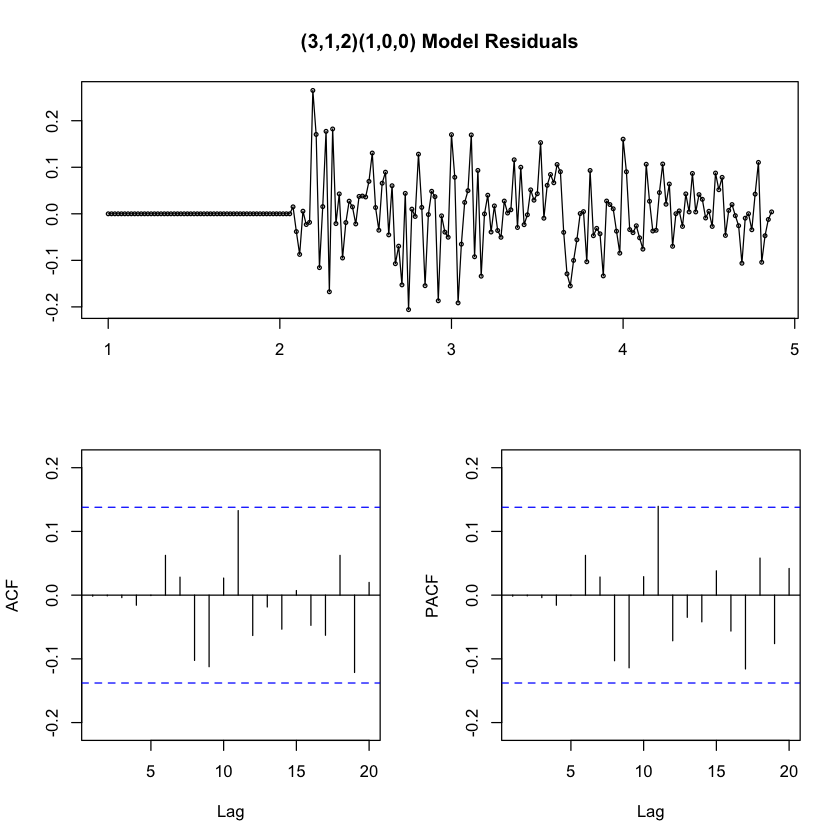

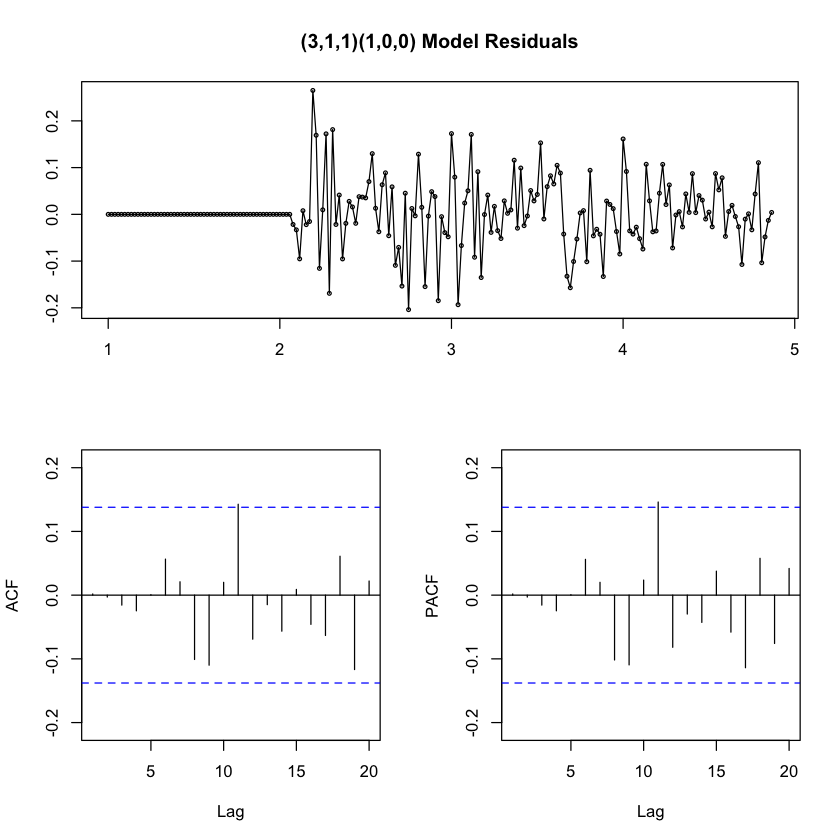

In [34]:
#fit ARIMA (3,1,2)(1,0,0) and (3,1,1)(1,0,0)
fit <- arima(weekly,order=c(3,1,2),seasonal = list(order=c(1,0,0),period=52),method='CSS')
fit2 <- arima(weekly,order=c(3,1,1),seasonal = list(order=c(1,0,0),period=52),method='CSS')

#look at model residuals
tsdisplay(residuals(fit), main='(3,1,2)(1,0,0) Model Residuals',lag.max = 20)
tsdisplay(residuals(fit2), main='(3,1,1)(1,0,0) Model Residuals',lag.max=20)

The above models and residuals look good. There are no significant PACF or ACF lags. Several other ARIMA models were fit and the RMSEs were compared. It was found that an ARIMA(0,1,2)(1,1,0) model produced the lowest RMSE value. 

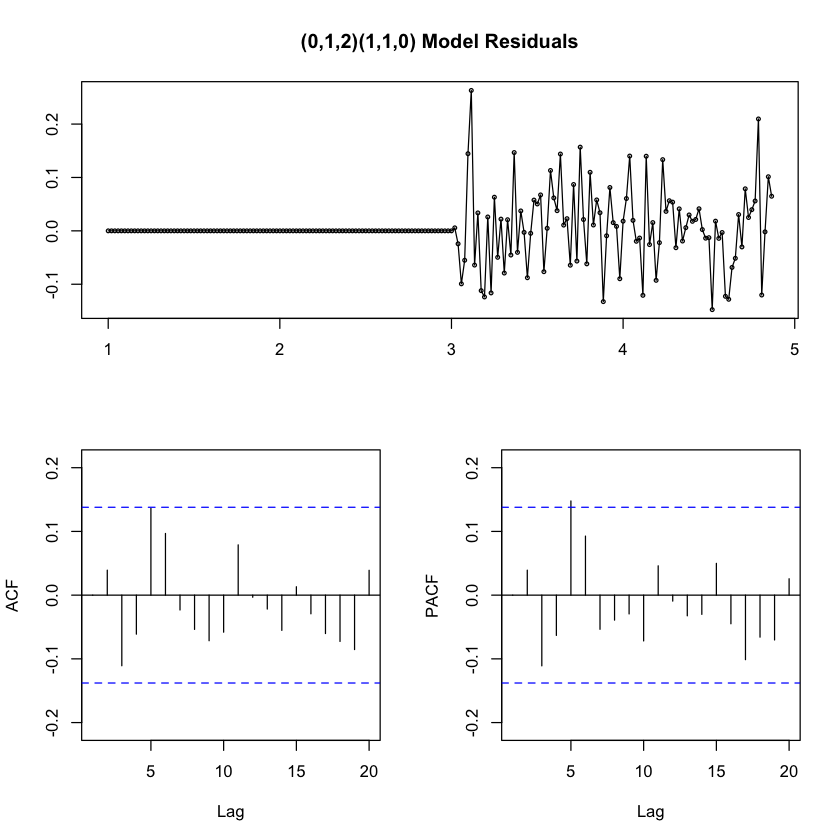

In [49]:
fit_best <- arima(weekly,order=c(0,1,2),seasonal = list(order=c(1,1,0),period=52),method='CSS')

#look at model residuals
tsdisplay(residuals(fit_best), main='(0,1,2)(1,1,0) Model Residuals',lag.max = 20)

The ARIMA(0,1,2)(1,1,0) model was used to forecast the Airbnb prices into the year 2021 and we can see that the predicted prices also show a similar pattern and seasonality to the observed Airbnb dataset.

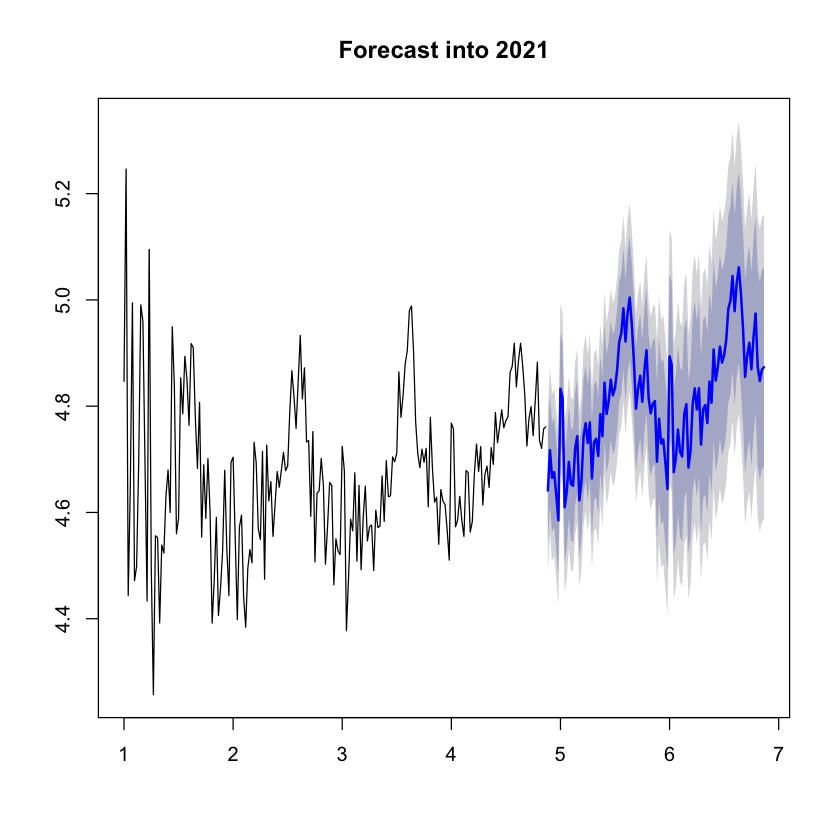

In [50]:
#train model
fitbest <- arima(weekly,order=c(0,1,2),seasonal = list(order=c(1,1,0),period=52),method='CSS')

#view predictions
fcast <- forecast(fitbest,h=104)

plot(fcast,main='Forecast into 2021')